# Studying the Two Running Games in Super Bowl LVII

_Note: You can consult the solution for this live training in the file browser (`notebook_solution.ipynb`)_

Every February millions of people, both inside and outside of North America, tune into the National Football League's Super Bowl, which crowns the world champion in American football.
In football there are two ways to advance the football while on offense; running and passing.
During this training, you will learn how to use data to see which players to watch out for during Super Bowl LVII in the running game, the more unheralded aspect of a football game.
We will show you how to obtain NFL play-by-play data in Python and then use exploratory data analysis and linear models to show which players will be the ones to watch during Super Bowl LVII. 

### Obtaining data and loading packages

While we use Python in this tutorial, the `nflfastR` play-by-play datatset was developed initially in R, and the package's [help page](https://www.nflfastr.com/articles/field_descriptions.html) that gives the best description of the metadata.
You can obtain data for any year using `import_pbp_data()` from the `nfl_data_py` package and we included this code commented out for your future reference.
However, we pre-stage the data for this live training as a csv file to optimize your learning experience.

First, load the required python packages.
Use `pandas` (alias `pd`) and `numpy` (alias `np`) for data.
Use `seaborn` (alias `sns`) and `matplotlib.pyplot` (alias `plt`) for plotting.
Use `statsmodels.formula.api` alias `smf` for linear models.

In [26]:
# import required packages
import numpy as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

**Note:** If you wanted to import the data for other seasons, you could use the code Eric and Richard used to obtain the original data:

```python
# code we used to obtain data
import nfl_data_py as nfl
pbp = nfl.import_pbp_data([2022])
# we only selected the columns we needed for today
pbp[['play_type', 'posteam', 'rushing_yards', 'rusher_id',
     'rusher_player_id', 'rusher_player_name', 'ydstogo', 'down',
     'yardline_100', 'run_location', 'score_differential',
     'game_seconds_remaining']].to_csv("pbp_2022.csv", index=False)
```

Now, you can load the _play-by-play_ (_pbp_, Python object `pbp`) data you'll use today using `pd.read_csv()` with `pbp_2022.csv`:

In [27]:
# load play-by-play data 
pbp = pd.read_csv('pbp_2022.csv')

Next, peak at the top of `pbp` using the `.head()`

In [28]:
# peak at head of pbp data
pbp.head()

,play_type,posteam,rushing_yards,rusher_id,rusher_player_id,rusher_player_name,ydstogo,down,yardline_100,run_location,score_differential,game_seconds_remaining
0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,3600.0
1,kickoff,NYJ,NaN,NaN,NaN,NaN,0.0,NaN,35.0,NaN,0.0,3600.0
2,run,NYJ,19.0,00-0036924,00-0036924,Mi.Carter,10.0,1.0,78.0,left,0.0,3596.0
3,pass,NYJ,NaN,NaN,NaN,NaN,10.0,1.0,59.0,NaN,0.0,3569.0
4,run,NYJ,5.0,00-0036924,00-0036924,Mi.Carter,10.0,2.0,59.0,left,0.0,3565.0


## Filtering Data to Rushing Plays

First, the `pbp` data needs to be filtered cleaned.
Use `query()` to preform the following:

* Save the new data frame as `pbp_run` because this is only the run play-by-play (_pbp_) data
* Filter (or, in `pandas` lingo, `query()`) to rushing plays with `play_type == "run"`
* Remove missing values for rushing_yards using `rushing_yards.notnull()`
* Remove missing values for rusher_id `rusher_id.notnull()`
* Rest the data frame's index, and 
* Look at the header of the data frame

Remember, use `&` to merge multiple filter criteria.
After filtering, look at the `head()` of the data:

In [29]:
# query pbp
pbp_run = pbp.query('play_type == "run" & rushing_yards.notnull() & rusher_id.notnull()').reset_index()

# peak at head of data
pbp_run.head()

,index,play_type,posteam,rushing_yards,rusher_id,rusher_player_id,rusher_player_name,ydstogo,down,yardline_100,run_location,score_differential,game_seconds_remaining
0,2,run,NYJ,19.0,00-0036924,00-0036924,Mi.Carter,10.0,1.0,78.0,left,0.0,3596.0
1,4,run,NYJ,5.0,00-0036924,00-0036924,Mi.Carter,10.0,2.0,59.0,left,0.0,3565.0
2,9,run,BAL,4.0,00-0034796,00-0034796,L.Jackson,2.0,3.0,64.0,right,0.0,3461.0
3,10,run,BAL,0.0,00-0033118,00-0033118,K.Drake,10.0,1.0,60.0,right,0.0,3421.0
4,12,run,BAL,1.0,00-0033118,00-0033118,K.Drake,2.0,3.0,52.0,right,0.0,3340.0


## Who Are the Best Rushers in Sunday's Game?

Next, you will examine which players are the best at rushing the football for the players will be in the game on Sunday.
First, select the data for the two teams in the Super Bowl, the Philadelphia Eagles (`PHI`) and the Kansas City Chiefs (`KC`) using the `isin` function from `pandas` with the Team of Possession (which team has the ball; `posteam`) column. To this,

1. Create a list of Super Bowl teams, `sb_teams`
2. Use the `.loc` command with `pbp_run` and the `.isin()` function on `posteam` column (**Hint:**, this looks like `pbp_run['posteam'].isin(sb_teams)`).
3. `reset_index()` on the new data frame
4. Save the outputs as `pbp_run_sb`

In [30]:
# create a list of teams in the Super Bowl
sb_teams = ['KC', 'PHI']
# Filter out only the Super Bowl teams using `isin()`
pbp_run_sb = pbp_run[pbp_run['posteam'].isin(sb_teams)].reset_index()

Next, check the data to make sure it is correct and you only have these two teams by using the `posteam` column and looking for the `unique()` values in the column:

In [31]:
# Look at the unique posteam values in `pbp_run_sb`
pbp_run_sb.posteam.unique()

array(['KC', 'PHI'], dtype=object)

Now, you can aggregate over the whole season for each player's rushing yards (sum of `rushing_yards`) and yards-per-carry (mean of `rushing yards`).
For this, "group by" the `posteam` so we know which team the player belongs to, and both `rusher_player_id` and `rusher_player_name` because some players have the same name.
Save this operation as `pbp_run_sb_yards`:

In [32]:
pbp_run_sb.head()

,level_0,index,play_type,posteam,rushing_yards,rusher_id,rusher_player_id,rusher_player_name,ydstogo,down,yardline_100,run_location,score_differential,game_seconds_remaining
0,303,1266,run,KC,9.0,00-0036360,00-0036360,C.Edwards-Helaire,10.0,1.0,75.0,middle,0.0,3600.0
1,304,1268,run,KC,7.0,00-0036360,00-0036360,C.Edwards-Helaire,10.0,1.0,65.0,middle,0.0,3532.0
2,305,1269,run,KC,18.0,00-0036360,00-0036360,C.Edwards-Helaire,3.0,2.0,58.0,left,0.0,3495.0
3,306,1273,run,KC,0.0,00-0036360,00-0036360,C.Edwards-Helaire,7.0,2.0,27.0,middle,0.0,3371.0
4,308,1283,run,KC,3.0,00-0036360,00-0036360,C.Edwards-Helaire,10.0,1.0,86.0,right,7.0,3163.0


In [33]:
# 1. use pbp_run_sb
# 2. groupby ["posteam", "rusher_player_id", "rusher_player_name"]
# 3. then aggregate `{"rushing_yards": ["sum", "mean", "count"]}`
# 4. save ouput as pbp_run_sb_yards
pbp_run_sb_yards = pbp_run_sb.groupby(["posteam", "rusher_player_id",               "rusher_player_name"]).agg({"rushing_yards": ["sum", "mean", "count"]})

In [34]:
pbp_run_sb_yards.head()

rushing_yards                
                                                      sum      mean count
posteam rusher_player_id rusher_player_name                              
KC      00-0030506       T.Kelce                      5.0  2.500000     2
        00-0031376       J.McKinnon                 317.0  3.643678    87
        00-0031595       M.Burton                     7.0  1.400000     5
        00-0033873       P.Mahomes                   20.0  3.333333     6
        00-0034272       M.Valdes-Scantling          -3.0 -3.000000     1

Next, get the `pbp_run_sb_yards` data ready to examine with two steps:
    
1. Filer using `.loc[]` with `pbp_run_sb_yards[('rushing_yards', 'count')] > 20` to look at only players with more than 20 rushing plays
2. Sort by the player's total rushing yards (`('rushing_yards', 'sum')`) with `ascending=[False]` to help us see who had the most yards

In [35]:
# Filter with pbp_run_sb[('rushing_yards', 'count')] > 20
# Look at the results by sorting by ('rushing_yards', 'sum')
pbp_run_sb_yards.loc[pbp_run_sb_yards[('rushing_yards', 'count')] > 20].sort_values(by=('rushing_yards', 'sum'), ascending=False)

rushing_yards                
                                                      sum      mean count
posteam rusher_player_id rusher_player_name                              
PHI     00-0035243       M.Sanders                 1401.0  4.881533   287
KC      00-0037197       I.Pacheco                  951.0  4.953125   192
PHI     00-0036389       J.Hurts                    521.0  4.378151   119
        00-0036919       K.Gainwell                 400.0  5.063291    79
KC      00-0031376       J.McKinnon                 317.0  3.643678    87
        00-0036360       C.Edwards-Helaire          302.0  4.253521    71
PHI     00-0034414       B.Scott                    270.0  4.090909    66

In [36]:
# Check out the resulting dataframe
pbp_run_sb_yards.head()

rushing_yards                
                                                      sum      mean count
posteam rusher_player_id rusher_player_name                              
KC      00-0030506       T.Kelce                      5.0  2.500000     2
        00-0031376       J.McKinnon                 317.0  3.643678    87
        00-0031595       M.Burton                     7.0  1.400000     5
        00-0033873       P.Mahomes                   20.0  3.333333     6
        00-0034272       M.Valdes-Scantling          -3.0 -3.000000     1

Notice also that the leading rusher for the Chiefs is Isiah Pacheco, who is a seventh-round pick in the most-recent NFL draft out of Rutgers

The Eagles' two leading rushers are their starting running back Miles Sanders and their quarterback Jalen Hurts.
This is just a subset of Hurts' overall rushing performance, since he often "scrambles" on passing plays, which count as rushing yards even though they are the result of passing plays.

Is this the end of the story? Give the time on the clock remaining for this live training, you can hopefully guess the answer.

## Rushing Yards Over Expected: Building linear model

The winning solution to the 2020 [Big Data Bowl](https://operations.nfl.com/gameday/analytics/big-data-bowl/), an analytics competition held by the NFL each year, resulted in the construction of an expectation metric for rushing yardage that depended on a number of factors.
From there, one can look at the residual between actual outcome an expected outcome - called rushing yards over expected (RYOE) for more insight into how well the rusher did relative to expectations.

Here, we fit a simple linear model based only on the number of yards to go for a first down.
Generally speaking, defenses play closer to the line of scrimmage when there are fewer yards to go, making rushing yardage harder to gain the closer `ydstogo` gets to 0.

* Use the `smf.ols()` function with `rushing_yards` predicted by an intercept and `ydstogo`.
* Use the input data `pbp_run`
* Save the output as `yard_to_go`

In [37]:
# use the smf.ols() with a formula and data
yards_to_go = smf.ols('rushing_yards ~ 1 + ydstogo ', data = pbp_run)

Next, extract the `fit()` and then `print()` the `summary()`:

In [38]:
# extract fit and then print() the summary
print(yards_to_go.fit().summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     96.54
Date:                Wed, 24 Apr 2024   Prob (F-statistic):           1.03e-22
Time:                        07:34:45   Log-Likelihood:                -45653.
No. Observations:               13995   AIC:                         9.131e+04
Df Residuals:                   13993   BIC:                         9.132e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3463      0.122     27.340      0.0

Notice that the coefficient for `ydstogo` is positive - a rusher is expected to gain more yards the further his team is from the first down market.
Let's explore the outcome of this model.

Lastly, create a new column, _run yards over expected_ or `ryoe` in `pbp_run` from `yard_to_go.fit().resid`:

In [39]:
# create ryoe column in pbp_run from the resid of yard_to_go.fit().resid
pbp_run['ryoe']  = yards_to_go.fit().resid

### RYOE for Super Bowl Rushers

First, you will need to filter out only the two teams in the Super Bowl.
You will results the object `sb_teams` from before, so you may need to go up and load this if you're jumping into the notebook now.
To do the filter, use the same `isin()` function as before (the new data frame is called pbp_ryoe_sb to be different from the previously data frame created above):

* Use `loc[]` with `pbp_run`
* use `isin()` with `sb_teams` and the `posteam` column from `pbp_run`
* Be sure to `reset_index()`
* Save the new data frame as `pbp_ryoe_sb`

In [40]:
# filter out sb teams to create pbp_ryoe_sb
pbp_ryoe_sb = pbp_run.loc[pbp_run['posteam'].isin(sb_teams)].reset_index()

In [41]:
pbp_ryoe_sb.head()

,level_0,index,play_type,posteam,rushing_yards,rusher_id,rusher_player_id,rusher_player_name,ydstogo,down,yardline_100,run_location,score_differential,game_seconds_remaining,ryoe
0,303,1266,run,KC,9.0,00-0036360,00-0036360,C.Edwards-Helaire,10.0,1.0,75.0,middle,0.0,3600.0,4.271583
1,304,1268,run,KC,7.0,00-0036360,00-0036360,C.Edwards-Helaire,10.0,1.0,65.0,middle,0.0,3532.0,2.271583
2,305,1269,run,KC,18.0,00-0036360,00-0036360,C.Edwards-Helaire,3.0,2.0,58.0,left,0.0,3495.0,14.239070
3,306,1273,run,KC,0.0,00-0036360,00-0036360,C.Edwards-Helaire,7.0,2.0,27.0,middle,0.0,3371.0,-4.313780
4,308,1283,run,KC,3.0,00-0036360,00-0036360,C.Edwards-Helaire,10.0,1.0,86.0,right,7.0,3163.0,-1.728417


Next, use the same grouping used before to calculate each player's rushing yards (sum of rushing_yards), yards-per-carry (mean of rushing yards), total rushing ards over expected (TYOE; sum of RYOE), and average RYOE (mean of RYOE):

In [42]:
# 1. create pbp_ryoe_sb_yards
# 2. use pbp_ryoe_sb
# 3. group by ["posteam", "rusher_player_id", "rusher_player_name"]
# 4. aggregate with "rushing_yards": ["sum", "mean"]
#    as well as "ryoe": ["sum", "mean", "count"]
pbp_ryoe_sb_yards = pbp_ryoe_sb.groupby(["posteam", "rusher_player_id", "rusher_player_name"]).\
    agg({"rushing_yards": ["sum", "mean"],
        "ryoe": ["sum", "mean", "count"]})

Let's look at the play-level distributions of these players for guys with more than 20 carries during the course of the season.
We include the cleaning code, because, while we spend most of our time cleaning data, we do not want this training to be a `pandas` session on cleaning data.

We used the value 20 because we only want players who had a large number of players:
First, clean up the column names to be easier to work with:

In [43]:
# first, flatten the columns of pbp_ryoe_sb_yards
pbp_ryoe_sb_yards.columns = list(map(''.join, pbp_ryoe_sb_yards.columns.values))

# Then rename columns
pbp_ryoe_sb_yards.rename(
                {
                    'rushing_yardssum':'Total rushing yards',
                    'rushing_yardsmean':'yards per play',
                    'ryoesum':'TYOE',
                    'ryoemean':'average RYOE',
                    'ryoecount':'carries'
                }, axis = 1, inplace=True)

# Query for carries >= 20
pbp_ryoe_sb_yards_20 = pbp_ryoe_sb_yards.query('carries >= 20').reset_index()

# Sort values by TYOE, ascending=False
pbp_ryoe_sb_yards_20.sort_values('TYOE', ascending = False)

,posteam,rusher_player_id,rusher_player_name,Total rushing yards,yards per play,TYOE,average RYOE,carries
4,PHI,00-0035243,M.Sanders,1401.0,4.881533,127.009855,0.442543,287
2,KC,00-0037197,I.Pacheco,951.0,4.953125,95.526355,0.497533,192
6,PHI,00-0036919,K.Gainwell,400.0,5.063291,60.317066,0.763507,79
5,PHI,00-0036389,J.Hurts,521.0,4.378151,29.635937,0.249041,119
1,KC,00-0036360,C.Edwards-Helaire,302.0,4.253521,-9.115828,-0.128392,71
3,PHI,00-0034414,B.Scott,270.0,4.090909,-21.758326,-0.329672,66
0,KC,00-0031376,J.McKinnon,317.0,3.643678,-72.258332,-0.830556,87


Notice that while Pacheco was close to Sanders in terms of yards per carry, and trailed him in total rushing yards, he is pretty close to him in total RYOE and is much better than he is in average RYOE per carry. 

Now, let's look at the data.
First, we need to extract the top players for the superbowl.
To do this,

1. Create `pbp_run_sb_20`
2. Use the `pbp_run` data
3. Filter using `.loc[]` with `pbp_run['rusher_player_id']` by `.isin(pbp_ryoe_sb_yards_20.rusher_player_id.unique())`

In [44]:
# Filter out only players with more than 20 carries
pbp_run_sb_20 = pbp_run.loc[pbp_run['rusher_player_id'].isin(pbp_ryoe_sb_yards_20.rusher_player_id.unique())]

We'll use a `seaborn` boxplot for each player:

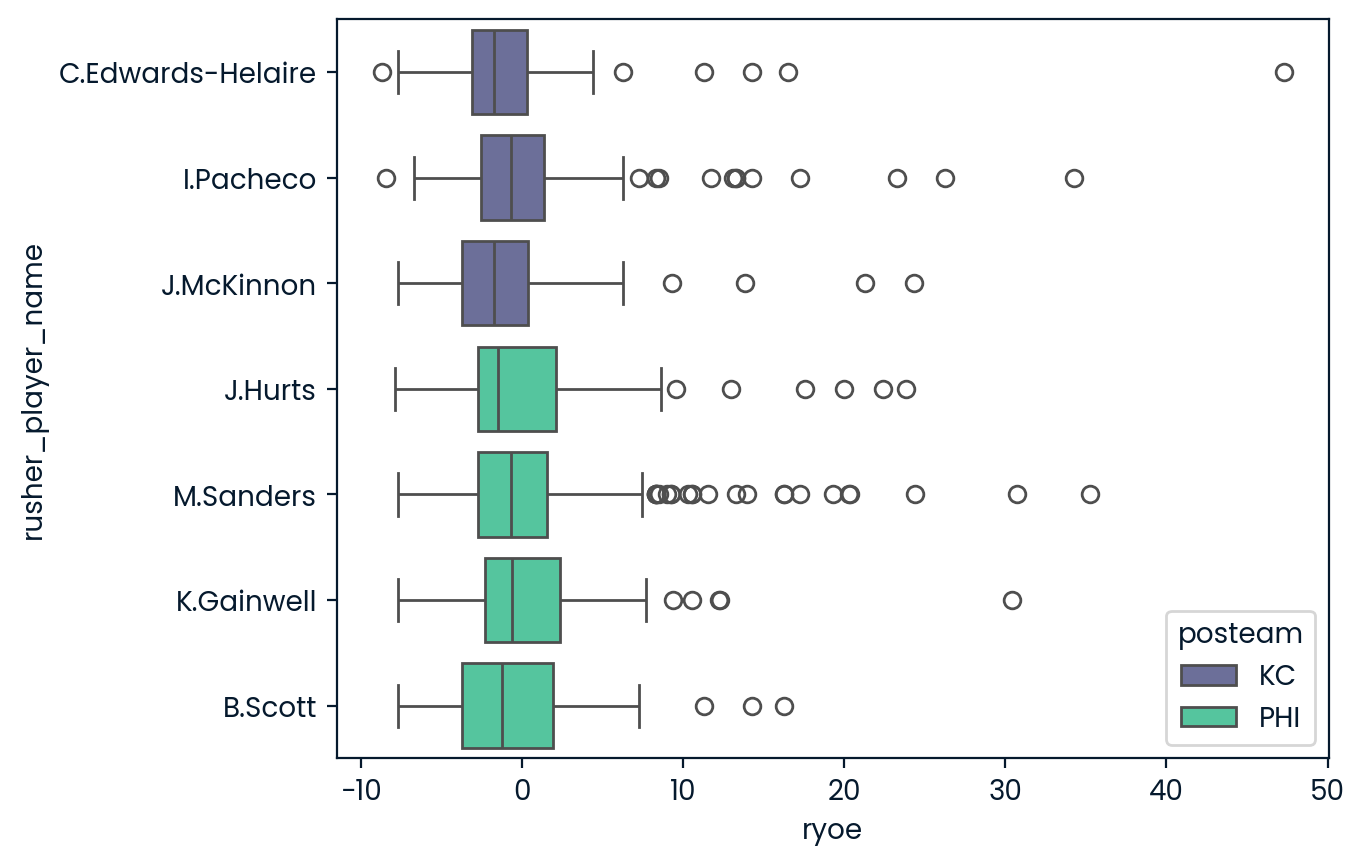

In [45]:
# Use sns boxplot
# x is ryoe, y is rusher_player_name, hue is posteam, data is pbp_run_sb_20
sns.boxplot(x = 'ryoe', y = 'rusher_player_name',
           hue = 'posteam', data = pbp_run_sb_20)
plt.show()

Notice that, while Jerick McKinnon has scored 9 touchdowns for the Chiefs this year, he's actually struggled running the ball relative to expectations pre-snap.
Former first-round pick Clyde Edwards-Helaire has ails well, with a negative RYOE, which opened the door for seventh-round pick Pacheco to shine.

### Conclusions for simple model

What have we learned from this simple modeling exercise?

* Rushing yards over expected is right skewed! 
* Sanders and Pacheco have shined, while Scott, Edwards-Helaire and McKinnon have struggled
* Much of data science, even with "package" data still requires data wrangling!

While anything can happen in Sunday's game, watch out for Sanders and Pacheco.

Lastly, check out our forthcoming book, [Football Analytics with Python & R](https://learning.oreilly.com/library/view/football-analytics-with/9781492099611/]) or our DataCamp courses to learn about [Linear Algebra in R](https://app.datacamp.com/learn/courses/linear-algebra-for-data-science-in-r), [Hierarchical and Mixed-effect Models in R](https://app.datacamp.com/learn/courses/hierarchical-and-mixed-effects-models-in-r), or [Generalized Linear Models in R](https://app.datacamp.com/learn/courses/generalized-linear-models-in-r).
And feel free to follow Eric on [Twitter](https://twitter.com/ericeager__) or [LinkedIn](https://www.linkedin.com/in/eric-eager-31a2a220) and Richard on [LinkedIn](https://www.linkedin.com/in/raerickson).

## Q and A

Questions?

### Multiple Regression

But, what about a more complex model? Can you do better at predicting?
As a bonus, we include the code for a more complicated model.

We have more powerful tools in our toolbox compared to a simple linear regression.
A next logical step would be to use multiple predictor variables and use a multiple regression.
There are other things that go into expected rushing success.
For example, which down it is?, how many yards the team has to go to reach the end zone?, what is the run direction?, what is the score differential? how much time is remaining?

Depending upon the purpose of the extra variables, you might say you are _correcting_ for other predictors (a term commonly used in the medical field, for example, when Richie Cotton worked at a Medical College he would have used the term).
Or, we may want to simply include multiple predictors.
However, this added realism comes at a trade-off of complexity.

If you are joining us late, please make sure you load the data from the previous part of the tutorial.
First, reformat `down` to be a string.
This will cause Python's regression to treat `down` as a category, rather than an a continuous predictor:

In [46]:
# Convert down from pbp_run to be a string using astype(str)
pbp_run['down'] = pbp_run.down.astype(str)

Next, let's build a model and examine the fit's summary.
Because the formula is long, define it first to make your code easier to read:

In [47]:
# include "rushing_yards ~ 1 + ydstogo + down + yardline_100 + run_location + score_differential + game_seconds_remaining"
m1_formula = "rushing_yards ~ 1 + ydstogo + down + yardline_100 + run_location + score_differential + game_seconds_remaining"

In [48]:
# next build the model, extract the fit, and print the summary
model1 = \
    smf.ols(formula = m1_formula, data = pbp_run)
model1_fit = model1.fit()
print(model1_fit.summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     26.68
Date:                Wed, 24 Apr 2024   Prob (F-statistic):           3.20e-46
Time:                        07:35:09   Log-Likelihood:                -45211.
No. Observations:               13872   AIC:                         9.044e+04
Df Residuals:                   13862   BIC:                         9.052e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2

Now, extract out RYOE, similar to and calculate the same summaries as before:

In [51]:
# extract out the residual from model 1
pbp_run['ryoe_m1'] = model1_fit.resid

# use .loc to extract out the sb_teams
pbp_ryoe_sb = pbp_run.loc[pbp['posteam'].isin(sb_teams)].reset_index()

# group by ["posteam", "rusher_player_id", "rusher_player_name"]
# aggregate with a dictionary
#    {"rushing_yards": ["sum", "mean"],
#     "ryoe": ["sum", "mean"],
#     "ryoe_m1": ["sum", "mean", "count"]})

pbp_ryoe_sb_yards = pbp_ryoe_sb.groupby(["posteam", "rusher_player_id", "rusher_player_name"]).agg({ "rushing_yards": ["sum", "mean"],
   "ryoe": ["sum", "mean"],
     "ryoe_m1": ["sum", "mean", "count"]})
# Filter to create top players with >20 plays data frame
pbp_ryoe_sb_yards_20 = pbp_ryoe_sb_yards.loc[pbp_ryoe_sb_yards[('ryoe_m1', 'count')] > 20] 
# sort and print outputs
pbp_ryoe_sb_yards_20.sort_values(('ryoe_m1', 'sum'), ascending = False)

rushing_yards  ... ryoe_m1
                                                      sum  ...   count
posteam rusher_player_id rusher_player_name                ...        
ATL     00-0037263       T.Allgeier                 193.0  ...      37
CIN     00-0033897       J.Mixon                    127.0  ...      23
CLE     00-0034791       N.Chubb                    182.0  ...      38
PIT     00-0036893       N.Harris                   188.0  ...      44
WAS     00-0037746       B.Robinson                 155.0  ...      39
TEN     00-0032764       D.Henry                     93.0  ...      31

[6 rows x 7 columns]

Next, filter for only players with more than 20 players.

In [52]:
pbp_ryoe_sb_20 = pbp_ryoe_sb[pbp_ryoe_sb['rusher_player_id'].isin(pbp_ryoe_sb_yards_20.reset_index().rusher_player_id.unique())]

In [54]:
pbp_ryoe_sb_20

,level_0,index,play_type,posteam,rushing_yards,rusher_id,rusher_player_id,rusher_player_name,ydstogo,down,yardline_100,run_location,score_differential,game_seconds_remaining,ryoe,ryoe_m1
7,1272,4856,run,CLE,-4.0,00-0034791,00-0034791,N.Chubb,10.0,1.0,79.0,right,7.0,2004.0,-8.728417,-9.290109
9,1274,4878,run,CLE,5.0,00-0034791,00-0034791,N.Chubb,10.0,1.0,80.0,left,0.0,1796.0,0.271583,-0.173001
12,1277,4885,run,CLE,2.0,00-0034791,00-0034791,N.Chubb,6.0,1.0,6.0,right,0.0,1548.0,-2.175568,-1.360647
15,1285,4921,run,CLE,9.0,00-0034791,00-0034791,N.Chubb,11.0,2.0,76.0,left,0.0,821.0,4.133370,3.287647
16,1286,4923,run,CLE,22.0,00-0034791,00-0034791,N.Chubb,10.0,1.0,62.0,left,0.0,743.0,17.271583,17.204654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,13440,47827,run,TEN,9.0,00-0032764,00-0032764,D.Henry,10.0,1.0,64.0,left,-4.0,163.0,4.271583,4.158924
862,13442,47843,run,CIN,6.0,00-0033897,00-0033897,J.Mixon,10.0,1.0,75.0,left,0.0,3600.0,1.271583,0.862398
864,13444,47850,run,CIN,11.0,00-0033897,00-0033897,J.Mixon,5.0,2.0,44.0,right,0.0,3339.0,6.962645,6.494242
867,13449,47870,run,CIN,1.0,00-0033897,00-0033897,J.Mixon,10.0,1.0,20.0,right,3.0,2765.0,-3.728417,-3.218777


The data requires one more manipulation, a melt, before the boxplot:

In [56]:
# melt 
pbp_ryoe_sb_20_long = \
    pd.melt(pbp_ryoe_sb_20[['posteam', 'rusher_player_id', 'rusher_player_name', 
                            'ryoe', 'ryoe_m1']].reset_index(),
           id_vars = ['posteam', 'rusher_player_id', 'rusher_player_name'],
           value_vars = ['ryoe', 'ryoe_m1'],
           var_name = 'Model',
            value_name = 'RYOE'
           )

<AxesSubplot: xlabel='RYOE', ylabel='rusher_player_name'>

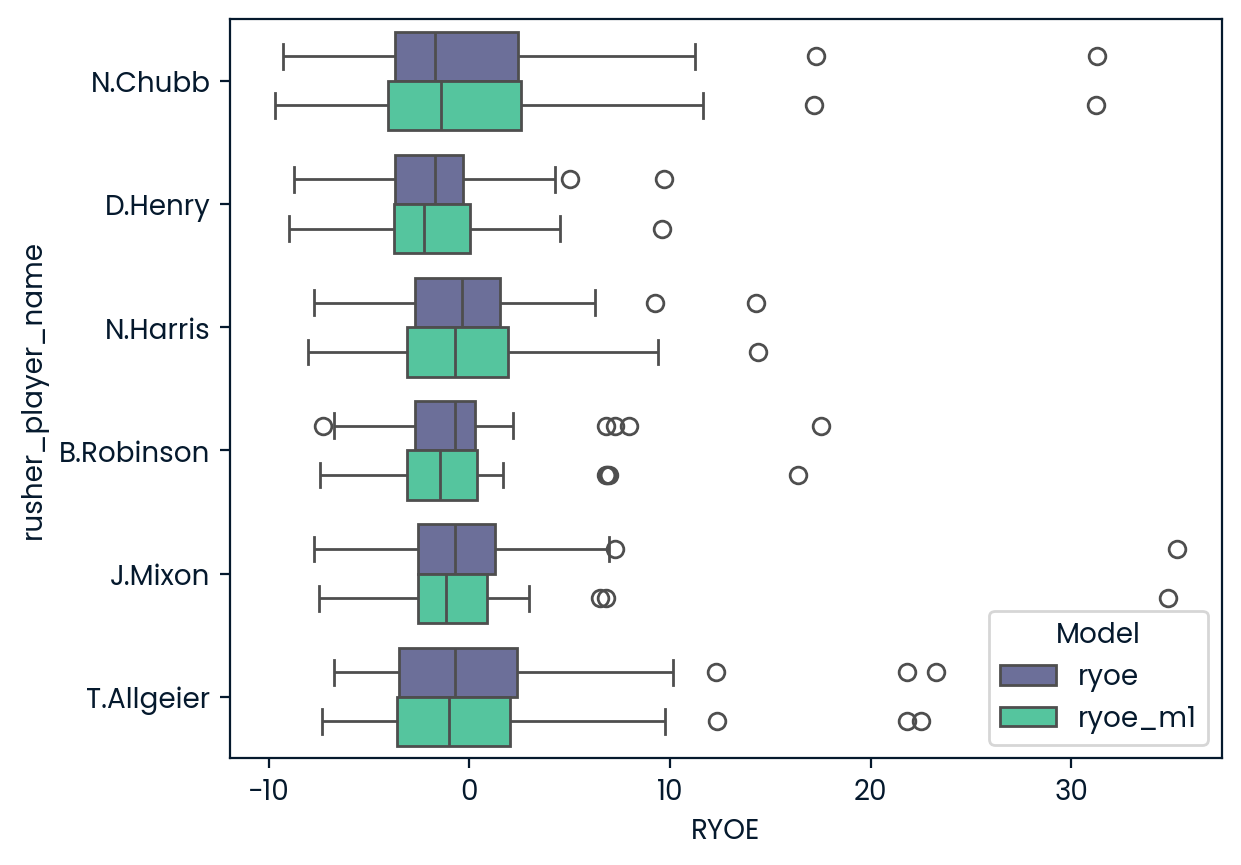

In [57]:
# sns boxplot
sns.boxplot(data = pbp_ryoe_sb_20_long, x = 'RYOE',
           y = 'rusher_player_name', hue = 'Model')

Notice here that results are largely the same.

# Conclusion

In this training session we looked at real National Football League play-by-play data to gain insights into the running game for Super Bowl LVII.

You saw how a multiple regression produced similar, but slightly different results than the simple regression.
As a data scientist, which model would you use?
Conversely, if you had to explain the model as a football analysts on live TV or radio, which model would you use?